## **Homework 3**

### *Narek Babajanyan*


### Exercise 1

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import roc_auc_score, mean_squared_error

In [69]:
data = pd.read_excel("https://github.com/HrantDavtyan/BA_BA/blob/master/Churn.xls?raw=true")

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Eve Mins          3333 non-null float64
Night Mins        3333 non-null float64
Intl Mins         3333 non-null float64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
VMail Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
State             3333 non-null object
Area Code         3333 non-null int64
Phone             3333 non-null object
dtypes: float64(8), int64(11), object(2)
memory usage: 546.9+ KB


In [71]:
#Since "Phone" is different for everyone, we dont need it
data = data.drop("Phone", axis = 1)

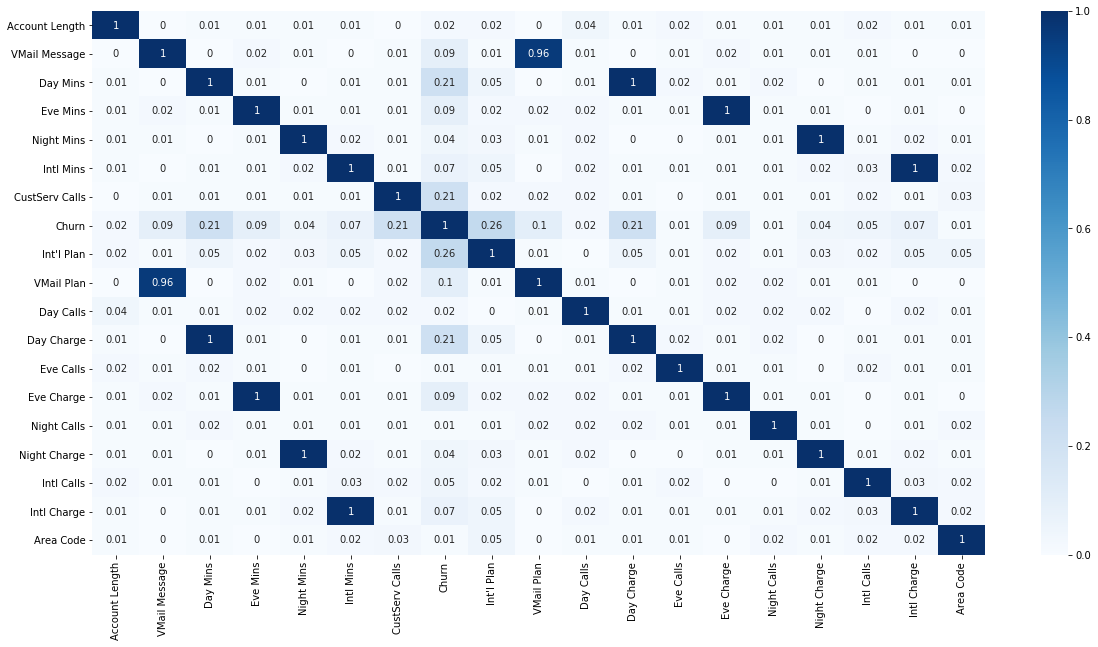

In [72]:
#State is the only remaining variable that needs to be converted to a dummy variable
state_old = pd.get_dummies(data["State"])
data = data.drop(["State"], axis = 1)
plt.figure(figsize=(20, 10))
sns.heatmap(data.corr().abs().round(2), annot=True, cmap="Blues")
plt.show()
data = data.join(state_old)

In [73]:
#We have cases of terribly high correlated variables, which we should remove
data = data.drop(["Day Mins"], axis = 1)
data = data.drop(["Eve Mins"], axis = 1)
data = data.drop(["Night Mins"], axis = 1)
data = data.drop(["Intl Mins"], axis = 1)
data = data.drop(["VMail Plan"], axis = 1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 65 columns):
Account Length    3333 non-null int64
VMail Message     3333 non-null int64
CustServ Calls    3333 non-null int64
Churn             3333 non-null int64
Int'l Plan        3333 non-null int64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
Area Code         3333 non-null int64
AK                3333 non-null uint8
AL                3333 non-null uint8
AR                3333 non-null uint8
AZ                3333 non-null uint8
CA                3333 non-null uint8
CO                3333 non-null uint8
CT                3333 non-null uint8
DC                3333 non-null uint8
DE                3333 non-null uint8
FL         

In [74]:
#Importing the 4 models we need to work with
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [75]:
model_dtc = DecisionTreeClassifier(class_weight = "balanced", random_state = 13)
model_lgr = LogisticRegression(class_weight = "balanced", random_state = 13)
model_rfc = RandomForestClassifier(class_weight = "balanced", random_state = 13)
model_gbc = GradientBoostingClassifier(random_state = 13)

In [76]:
#This will be our main dataset to feed to models
y = data.Churn
X = data.drop("Churn", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.25)

In [77]:
#We use this function to evaluate hyperparameter tuning results.
#Copied from http://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [78]:
#Because we have models with multiple hyperparameters
#We should start tuning them for maximum performance
#Let's start with the decision tree

params_dtc = {"max_depth": [3, 5, 7, 9, 11, None],
               "max_features": sp_randint(1, 11),
               "min_samples_split": sp_randint(2, 11),
               "min_samples_leaf": sp_randint(1, 11),
               "criterion": ["gini", "entropy"]}

iterations = 50

#SKLearn's documentation mentions the possibility of multimetric scoring 
#Out of curiosity, I tried to implement this.
#However, SKLearn complained about the value of the "refit" parameter
#So I will just go with 'roc_auc'
RSCV_dtc = RandomizedSearchCV(model_dtc, param_distributions = params_dtc,
                                   n_iter = iterations, random_state = 13, scoring = "roc_auc")
RSCV_dtc.fit(X, y)
report(RSCV_dtc.cv_results_)

best_dtc = RSCV_dtc.best_estimator_
best_dtc.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_dtc.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_dtc.score(X_test, y_test)))

pred_train = best_dtc.predict(X_train)
print("AUC for the training set is " + str(roc_auc_score(y_train, pred_train)))
pred_test = best_dtc.predict(X_test)
print("AUC for the test set is " + str(roc_auc_score(y_test, pred_test)))

Model with rank: 1
Mean validation score: 0.804 (std: 0.013)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.789 (std: 0.009)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 8, 'min_samples_leaf': 8, 'min_samples_split': 7}

Model with rank: 3
Mean validation score: 0.785 (std: 0.018)
Parameters: {'criterion': 'entropy', 'max_depth': 11, 'max_features': 7, 'min_samples_leaf': 6, 'min_samples_split': 6}

Accuracy for training set is 0.83793517407
Accuracy for test set is 0.814148681055
AUC for the training set is 0.832141953194
AUC for the test set is 0.788552891396


In [79]:
#Moving on to logistic regression
#Since we're dealing with numerical variables, 
#Logistic regression needs scaling
from sklearn import preprocessing

minmax = preprocessing.MinMaxScaler()
X_scaled = minmax.fit_transform(X)

params_lgr = {"penalty": ['l2'],
                "dual": [True, False],
                "C": np.arange(0.5, 10, 0.5)}

#I was recommended by an SKLearn error to use GridSearchCV for "extensive search"
#Which is why this section is discarded
#RSCV_lgr = RandomizedSearchCV(model_lgr, param_distributions = params_lgr,
#                                  n_iter=iterations, random_state=13, scoring="roc_auc")
#RSCV_lgr.fit(X_scaled, y)
#report(RSCV_lgr.cv_results_)

GSCV_lgr = GridSearchCV(model_lgr, param_grid = params_lgr, scoring = 'roc_auc')
GSCV_lgr.fit(X_scaled, y)
report(GSCV_lgr.cv_results_)

best_lgr = GSCV_lgr.best_estimator_
best_lgr.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_lgr.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_lgr.score(X_test, y_test)))

pred_train = best_lgr.predict(X_train)
print("AUC for the training set is " + str(roc_auc_score(y_train, pred_train)))
pred_test = best_lgr.predict(X_test)
print("AUC for the test set is " + str(roc_auc_score(y_test, pred_test)))

Model with rank: 1
Mean validation score: 0.804 (std: 0.015)
Parameters: {'C': 1.0, 'dual': True, 'penalty': 'l2'}

Model with rank: 2
Mean validation score: 0.804 (std: 0.015)
Parameters: {'C': 1.0, 'dual': False, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.804 (std: 0.014)
Parameters: {'C': 1.5, 'dual': True, 'penalty': 'l2'}

Model with rank: 3
Mean validation score: 0.804 (std: 0.014)
Parameters: {'C': 1.5, 'dual': False, 'penalty': 'l2'}

Accuracy for training set is 0.857142857143
Accuracy for test set is 0.850119904077
AUC for the training set is 0.501396648045
AUC for the test set is 0.5


In [80]:
params_gbc = {"loss": ['deviance', 'exponential'],
             "learning_rate": np.arange(0.1, 1.5, 0.1),
             "max_depth": [3, 5, 7, 9, 11, None],
             "min_samples_split": sp_randint(2, 11),
             "min_samples_leaf": sp_randint(1, 11),
             "subsample": [0.5, 0.7, 1],
             "max_features": ['auto', None]}

RSCV_gbc = RandomizedSearchCV(model_gbc, param_distributions = params_gbc,
                                   n_iter = iterations, random_state = 13, scoring = 'roc_auc')
RSCV_gbc.fit(X, y)
report(RSCV_gbc.cv_results_)

best_gbc = RSCV_gbc.best_estimator_
best_gbc.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_gbc.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_gbc.score(X_test, y_test)))

pred_train = best_gbc.predict(X_train)
print("AUC for the training set is " + str(roc_auc_score(y_train, pred_train)))
pred_test = best_gbc.predict(X_test)
print("AUC for the test set is " + str(roc_auc_score(y_test, pred_test)))

Model with rank: 1
Mean validation score: 0.919 (std: 0.007)
Parameters: {'learning_rate': 0.10000000000000001, 'loss': 'deviance', 'max_depth': 11, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 8, 'subsample': 0.7}

Model with rank: 2
Mean validation score: 0.916 (std: 0.011)
Parameters: {'learning_rate': 0.20000000000000001, 'loss': 'exponential', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 9, 'subsample': 0.5}

Model with rank: 3
Mean validation score: 0.916 (std: 0.008)
Parameters: {'learning_rate': 0.10000000000000001, 'loss': 'exponential', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'subsample': 0.5}

Accuracy for training set is 1.0
Accuracy for test set is 0.954436450839
AUC for the training set is 1.0
AUC for the test set is 0.867768688293


In [81]:
params_rfc = {"n_estimators": [10, 20, 30],
             "max_features": ['auto', None],
             "min_samples_split": sp_randint(2, 11),
             "min_samples_leaf": sp_randint(1, 11),
             "bootstrap": [True, False],
             "criterion": ["gini", "entropy"]}

RSCV_rfc = RandomizedSearchCV(model_rfc, param_distributions = params_rfc,
                                   n_iter = iterations, random_state = 13, scoring = 'roc_auc')
RSCV_rfc.fit(X, y)
report(RSCV_rfc.cv_results_)

best_rfc = RSCV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_rfc.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_rfc.score(X_test, y_test)))

pred_train = best_rfc.predict(X_train)
print("AUC for the training set is " + str(roc_auc_score(y_train, pred_train)))
pred_test = best_rfc.predict(X_test)
print("AUC for the test set is " + str(roc_auc_score(y_test, pred_test)))

Model with rank: 1
Mean validation score: 0.914 (std: 0.010)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20}

Model with rank: 2
Mean validation score: 0.908 (std: 0.007)
Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.907 (std: 0.010)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 20}

Accuracy for training set is 0.999599839936
Accuracy for test set is 0.938848920863
AUC for the training set is 0.999766464269
AUC for the test set is 0.832242595205


### Exercise 2

In [90]:
data = pd.read_csv('https://github.com/HrantDavtyan/Business_Analytics/blob/master/CLV.csv?raw=true')

In [103]:
data.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,2/3/11,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


In [99]:
from sklearn import preprocessing

In [109]:
le = preprocessing.LabelEncoder()
dataEncoded = data.apply(le.fit_transform)
dataEncoded.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,600,4,975,0,0,0,47,1,0,3322,1,1,8,32,5,0,0,0,2,0,0,2941,5,1
1,5946,0,4659,0,1,0,24,4,0,0,1,2,32,13,42,0,7,1,5,2,0,4880,0,1
2,96,2,6900,0,2,0,41,1,0,2820,1,1,46,18,38,0,1,1,5,0,0,3897,5,1
3,8016,1,5140,0,0,0,12,4,1,0,1,1,44,18,65,0,6,0,1,0,2,3764,3,1
4,2488,4,1058,0,0,0,52,1,1,2510,0,2,12,12,44,0,0,1,3,0,0,1138,0,1


In [115]:
y = dataEncoded["Customer Lifetime Value"]
X = dataEncoded.drop("Customer Lifetime Value", axis = 1)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 13, test_size = 0.25)

In [112]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [113]:
model_dtr = DecisionTreeRegressor(random_state = 13)
model_lnr = LinearRegression()
model_rfr = RandomForestRegressor(random_state = 13)
model_gbr = GradientBoostingRegressor(random_state = 13)

In [120]:
#Decision Tree Regressor
param_dtr = {"max_depth": [3, 5, 7, 9, 11, None],
               "max_features": sp_randint(1, 7),
               "min_samples_split": sp_randint(2, 11),
               "min_samples_leaf": sp_randint(1, 11),
               "criterion": ["mse", "friedman_mse", "mae"]}


RSCV_dtr = RandomizedSearchCV(model_dtr, param_distributions = param_dtr,
                                   n_iter = iterations, random_state = 13, scoring = 'neg_mean_squared_error', cv = 5)
RSCV_dtr.fit(X, y)

best_dtr = RSCV_dtr.best_estimator_
best_dtr.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_dtr.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_dtr.score(X_test, y_test)))

pred_train = best_dtr.predict(X_train)
print("MSE for the training set is " + str(-mean_squared_error(y_train, pred_train) / 1000 ))
pred_test = best_dtr.predict(X_test)
print("MSE for the test set is " + str(-mean_squared_error(y_test, pred_test) / 1000 ))

Accuracy for training set is 0.956130275178
Accuracy for test set is 0.913305643469
MSE for the training set is -237.731688978
MSE for the test set is -469.523753174


In [119]:
#Linear Regression
model_lnr.fit(X, y)
print("Accuracy for training set is " + str(model_lnr.score(X_train, y_train)))
print("Accuracy for test set is " + str(model_lnr.score(X_test, y_test)))

pred_train = model_lnr.predict(X_train)
print("MSE for the training set is " + str(-mean_squared_error(y_train, pred_train) / 1000 ))
pred_test = model_lnr.predict(X_test)
print("MSE for the test set is " + str(-mean_squared_error(y_test, pred_test) / 1000 ))

Accuracy for training set is 0.27495787243
Accuracy for test set is 0.295714704898
MSE for the training set is -3929.0305619
MSE for the test set is -3814.30450945


In [122]:
#Random Forest Regressor
param_rfr = {"n_estimators": [20, 30],
             "max_features": ['auto', None],
             "min_samples_split": sp_randint(2, 11),
             "min_samples_leaf": sp_randint(1, 11),
             "bootstrap": [True, False]}


RSCV_rfr = RandomizedSearchCV(model_rfr, param_distributions = param_rfr,
                                   n_iter = iterations, random_state = 13, scoring = 'neg_mean_squared_error', cv = 5)
RSCV_rfr.fit(X, y)

best_rfr = RSCV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_rfr.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_rfr.score(X_test, y_test)))

pred_train = best_rfr.predict(X_train)
print("MSE for the training set is " + str(-mean_squared_error(y_train, pred_train) / 1000 ))
pred_test = best_rfr.predict(X_test)
print("MSE for the test set is " + str(-mean_squared_error(y_test, pred_test) / 1000 ))

Accuracy for training set is 0.990283935386
Accuracy for test set is 0.971266457973
MSE for the training set is -52.6517196123
MSE for the test set is -155.61659414


In [ ]:
#Gradient Boosted Regressor
param_gbr = {"learning_rate": np.arange(0.1, 1.5, 0.1),
             "max_depth": [3, 5, 7, 9, 11, None],
             "min_samples_split": sp_randint(2, 11),
             "min_samples_leaf": sp_randint(1, 11),
             "subsample": [0.5, 0.7, 1],
             "max_features": ['auto', None]}

RSCV_gbr = RandomizedSearchCV(model_gbr, param_distributions = param_gbr,
                                   n_iter = iterations, random_state = 13, scoring = 'neg_mean_squared_error', cv = 5)
RSCV_gbr.fit(X, y)

best_gbr = RSCV_gbr.best_estimator_
best_gbr.fit(X_train, y_train)

print("Accuracy for training set is " + str(best_gbr.score(X_train, y_train)))
print("Accuracy for test set is " + str(best_gbr.score(X_test, y_test)))

pred_train = best_gbr.predict(X_train)
print("MSE for the training set is " + str(-mean_squared_error(y_train, pred_train) / 1000 ))
pred_test = best_gbr.predict(X_test)
print("MSE for the test set is " + str(-mean_squared_error(y_test, pred_test) / 1000 ))